# Simple Model Fit

In [1]:
suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(DESeq2))

In [2]:
source('../prj_helpers.R')

In [3]:
# load pre-qc'ed data
se.qc <- readRDS('../03-sample_qc/se.qc.rds')

In [4]:
colData(se.qc)

DataFrame with 308 rows and 68 columns
                                            file_identifiers A.identifier
                                                 <character>  <character>
A0001_S121_L002                              A0001_S121_L002        A0001
A0002_S124_L002                              A0002_S124_L002        A0002
A0003                                                  A0003        A0003
A0006_S89_L002                                A0006_S89_L002        A0006
A0007_S17_L001                                A0007_S17_L001        A0007
...                                                      ...          ...
Zyagen_D000_Ovary.160421_long_S15     Zyagen_D000_Ovary.16..           NA
Zyagen_D000_Skin.190507_long_S2       Zyagen_D000_Skin.190..           NA
Zyagen_D000_SpinalCord.190507_long_S8 Zyagen_D000_SpinalCo..           NA
Zyagen_D000_Spleen.190507_long_S1     Zyagen_D000_Spleen.1..           NA
Zyagen_D000_Testis.160421_long_S16    Zyagen_D000_Testis.1..           NA

In [5]:
se.qc.experimental <- se.qc[,se.qc$SampleType == 'Experimental']

In [6]:
se.qc.experimental <- se.qc.experimental[!rowData(se.qc.experimental)$viralGene,]

In [7]:
se.qc.experimental <- se.qc.experimental[,!(se.qc.experimental$tissue %in% c('PBMC','Liver','Whole blood','Lung'))]

In [8]:
se.qc.experimental$tissue.full <- as.factor(paste0(as.character(se.qc.experimental$tissue), '.', se.qc.experimental$sub.tissue))

In [9]:
se.qc.experimental$infected <- factor(ifelse(se.qc.experimental$dpi_time > 0,'infected','noninfected'),levels=c('infected','noninfected'))

In [10]:
se.qc.experimental$sex <- as.factor(se.qc.experimental$sex)

In [11]:
se.qc.experimental$tissue <- as.factor(as.character(se.qc.experimental$tissue))

In [12]:
dim(colData(se.qc.experimental))

[1] 193  70

In [13]:
table(colData(se.qc.experimental)[,c('full.tissue','infected')])

                     infected
full.tissue           infected noninfected
  Adrenal Gland              7           3
  Brain:Brain-Gr            18           3
  Brain:Brain-Wh             8           1
  Kidney                    17           3
  Liver                      0           0
  Lung                       0           0
  Lymph node:LN-AX-R        18           3
  Lymph node:LN-ING-L       18           3
  Lymph node:LN-MES         18           3
  Lymph node:NA              0           0
  Ovary                      0           0
  PBMC                       0           0
  Sex Organ:Ovary            9           1
  Sex Organ:Sex-Organ        7           2
  Sex Organ:Testis           5           0
  Skin                       0           0
  Skin:Non-Rash             12           3
  Skin:Rash                  9           2
  SpinalCord                 0           0
  Spleen                    17           3
  Testis                     0           0
  Whole blood           

In [14]:
dds.qc.experimental <- DESeqDataSet(se.qc.experimental, design=~ tissue + infected + tissue:infected)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [15]:
# Remove genes that are not well-expressed to resolve convergence issues 
dds.qc.experimental <- estimateSizeFactors(dds.qc.experimental)
nc <- counts(dds.qc.experimental, normalized = TRUE)
filter <- rowSums(nc >= 10) >= 2
table(filter)
dds.qc.experimental <- dds.qc.experimental[filter,]


  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



filter
FALSE  TRUE 
11435 23960 

In [16]:
dds.qc.experimental <- estimateSizeFactors(dds.qc.experimental)
dds.qc.experimental <- estimateDispersions(dds.qc.experimental)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



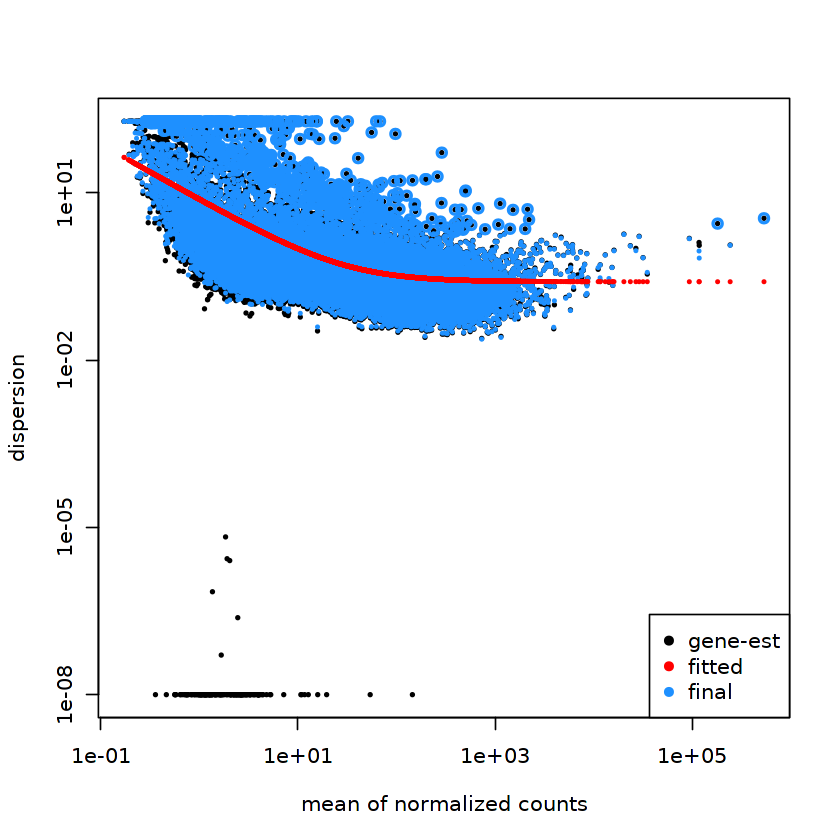

In [17]:
plotDispEsts(dds.qc.experimental)

In [18]:
dds.qc.experimental <- nbinomWaldTest(dds.qc.experimental, maxit = 5000)

143 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



In [19]:
convergedGenes <- which(mcols(dds.qc.experimental)$betaConv)
table(mcols(dds.qc.experimental)$betaConv)


FALSE  TRUE 
  143 23817 

In [20]:
# Remove the genes that don't converge
dds.qc.experimental <- dds.qc.experimental[convergedGenes,]

In [21]:
saveRDS(dds.qc.experimental,'dds.qc.experimental_simple_model.rds')

In [22]:
saveRDS(se.qc.experimental,'se.qc.experimental.rds')

In [23]:
table(colData(dds.qc.experimental)[,c('tissue','infected')])

               infected
tissue          infected noninfected
  Adrenal Gland        7           3
  Brain               26           4
  Kidney              17           3
  Lymph node          54           9
  Sex Organ           21           3
  Skin                21           5
  Spleen              17           3